In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [4]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [6]:
# those three are created from storm cut out kernels (storm netcdf files needed!)

OBS3 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-40_zeroRain_gt5k_-40thresh_OBSera.p', 'rb'))
OBS = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_TRMM_ERA-I.p', 'rb'))
OBS2 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_ERA-I.p', 'rb'))

In [7]:
OBS2.keys()

dict_keys(['lat', 'shear', 'month', 'pv650', 'year', 'tmin', 'rh925', 'pmax', 'q650', 'clat', 't650', 'tmean', 't925', 'pgt01isvalid', 'v650', 'div925', 'q925', 'area', 'div650', 'pv925', 'rh650', 'w650', 'p', 'u925', 'w925', 't', 'lon', 'hour', 'v925', 'pgt30', 'u650', 'clon', 'pmean'])

(array([8.7588e+04, 3.8645e+04, 2.0713e+04, 1.2476e+04, 8.5300e+03,
        6.0640e+03, 4.6990e+03, 3.6490e+03, 2.8980e+03, 2.3130e+03,
        1.8870e+03, 1.4870e+03, 1.2700e+03, 1.0380e+03, 9.3100e+02,
        7.0600e+02, 6.5300e+02, 5.3000e+02, 4.7900e+02, 3.9000e+02,
        3.0400e+02, 2.6800e+02, 2.4300e+02, 1.9900e+02, 1.7900e+02,
        1.4200e+02, 1.3300e+02, 9.7000e+01, 9.9000e+01, 8.7000e+01,
        6.3000e+01, 6.2000e+01, 5.1000e+01, 4.0000e+01, 3.0000e+01,
        2.7000e+01, 1.9000e+01, 2.8000e+01, 1.6000e+01, 1.6000e+01,
        1.6000e+01, 1.6000e+01, 1.4000e+01, 1.0000e+01, 1.0000e+01,
        6.0000e+00, 7.0000e+00, 8.0000e+00, 1.0000e+00, 8.0000e+00]),
 array([  1.  ,   2.98,   4.96,   6.94,   8.92,  10.9 ,  12.88,  14.86,
         16.84,  18.82,  20.8 ,  22.78,  24.76,  26.74,  28.72,  30.7 ,
         32.68,  34.66,  36.64,  38.62,  40.6 ,  42.58,  44.56,  46.54,
         48.52,  50.5 ,  52.48,  54.46,  56.44,  58.42,  60.4 ,  62.38,
         64.36,  66.34,  68.32

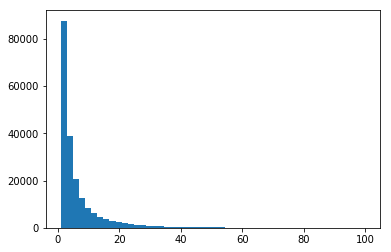

In [8]:
pp = []
for p in OBS['p']:
    pp.extend(np.array(p).flatten())
parr = np.array(pp)
plt.hist(parr, range=(1,100), bins=50)

In [9]:
def create_dic(dic):
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shear']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])
    umax = np.array(dic['u925'])
    qq = np.array(dic['q925']) 
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])

    obs_pcp = {
        'prcp' : pp,
        'u650' : umin,
        'u925' : umax,
        'q925' : qq*1000,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'tmean' : ttm,
        'lat' : lat,
        'lon' : lon,
    } 
    obs = pd.DataFrame(obs_pcp)
    return obs

In [10]:
obs_trmm = create_dic(OBS)
obs_gpm = create_dic(OBS2)
obs_40 = create_dic(OBS3)

In [11]:
obs_trmm = obs_trmm[(obs_trmm.lon>=-10)&(obs_trmm.lon<=12)&(obs_trmm.lat>=5.2)&(obs_trmm.lat<=8.3)]
obs_gpm = obs_gpm[(obs_gpm.lon>=-10)&(obs_gpm.lon<=12)&(obs_gpm.lat>=5.2)&(obs_gpm.lat<=8.3)]
obs_40 = obs_40[(obs_40.lon>=-10)&(obs_40.lon<=12)&(obs_40.lat>=5.2)&(obs_40.lat<=8.3)]

In [12]:
obs_gpm

,area,lat,lon,month,prcp,q925,shear,tmean,tmin,u650,u925
0,15175,8.042260,7.086056,7,16.436291,14.771931,4.242306,-59.368354,-66.000000,-0.871464,3.370841
2,25900,5.383124,5.871901,3,40.799622,15.283607,11.599382,-67.618949,-84.491096,-8.650678,2.948704
3,18875,5.657608,9.794786,3,41.538076,11.851226,5.548393,-68.572320,-81.253862,-4.378613,1.169780
4,8625,5.251607,11.170472,8,4.185770,16.826462,-0.868521,-59.640201,-68.415718,3.606708,2.738187
5,5625,6.794109,9.875093,3,0.027387,14.376267,14.587403,-61.164508,-71.528749,-12.508322,2.079082
7,5050,6.118873,-0.763059,11,25.979994,15.512910,5.897785,-63.932756,-76.043866,-4.892231,1.005554
8,9175,7.607427,-9.920333,8,3.956107,14.651157,-1.993850,-57.010670,-65.814378,4.999868,3.006018
9,6350,6.134304,7.743775,8,9.723751,14.361298,6.079646,-64.095732,-74.291615,-3.830828,2.248818
10,12700,5.550144,11.265918,8,16.874041,15.085265,1.735940,-57.706569,-71.352158,-1.495301,0.240639
11,11425,5.398523,10.319106,8,5.116616,12.737813,3.269078,-58.910107,-67.941221,-1.111741,2.157337


In [13]:
print('OBS_40', obs_40.lat.min(), obs_40.lat.max(), obs_40.lon.min(), obs_40.lon.max())
print('OBS_trmm', obs_trmm.lat.min(), obs_trmm.lat.max(), obs_trmm.lon.min(), obs_trmm.lon.max())
print('OBS_gpm', obs_gpm.lat.min(), obs_gpm.lat.max(), obs_gpm.lon.min(), obs_gpm.lon.max())

OBS_40 5.202033158482649 8.27489747441562 -9.903745996969064 11.95447649051051
OBS_trmm 5.202948463139375 8.299489120459318 -9.985909169988865 11.952369398805448
OBS_gpm 5.200264171289404 8.299464319878636 -9.999797285878543 11.789464732209554


In [14]:
obs_trmm.keys()

Index(['area', 'lat', 'lon', 'month', 'prcp', 'q925', 'shear', 'tmean', 'tmin',
       'u650', 'u925'],
      dtype='object')

Text(0.5, 1.0, '-0.53')

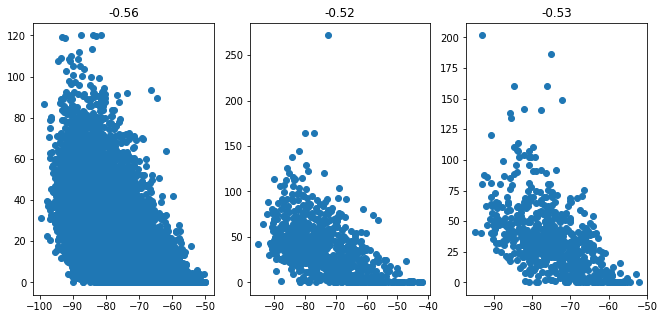

In [15]:
obss = [obs_trmm.tmin, obs_trmm.prcp]
cp4s = [obs_gpm.tmin, obs_gpm.prcp]
cp25s = [obs_40.tmin, obs_40.prcp]


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(131)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(132)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(133)
plt.scatter(obss[0],obss[1])
r = stats.pearsonr(obss[0],obss[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,150)
#ax.set_ylim(13,19)


In [16]:
tl = []
for m in range(2,12):
    try:
        dat = obs_trmm[(obs_trmm.month==m)]
        out = np.percentile(np.array(dat['prcp'])[dat['prcp']>1], 75)
    except:
        continue
    print(m,out)
    tl.append(out)

3 48.1203250770809
4 49.13789650558766
5 51.59100935992765
6 53.93305802326755
7 51.208678829315254
8 43.944735224048046
9 45.979377222321425
10 47.346190686024386
11 43.86303304587092


In [17]:
pl = []
for m in range(2,12):
    try:
        dat = obs_gpm[obs_gpm.month==m]
        out = np.percentile(np.array(dat['prcp'])[dat['prcp']>1], 98)
    except:
        continue
    print(m,out)
    pl.append(out)

3 65.28584833330356
4 71.63341353336666
5 80.11830809731488
7 67.9647141329536
8 58.75455710508828
10 62.21579442876055
11 59.27289533670911


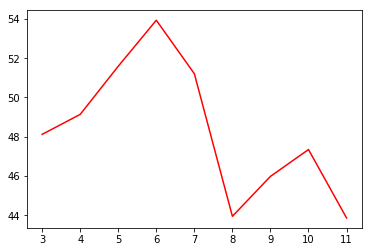

In [18]:
#plt.plot(np.arange(3,12), pl)
plt.plot(np.arange(3,12), tl, 'r')

In [19]:
era_out = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_allmonth_5-8N_2000-2014_18UTC_front.p', 'rb'))

In [20]:
ts=pd.Series(np.array(era_out['dates']))

In [21]:
ts.dt.month.values

array([ 1,  1,  1, ..., 12, 12, 12])

In [22]:
e_u650 = np.array(era_out['u650'])
e_u925 = np.array(era_out['u925'])
e_q925 = np.array(era_out['q925'])
e_q700 = np.array(era_out['q700'])
ttg = np.array(era_out['tmin'])
ttm = np.array(era_out['tmean'])
lat = np.array(era_out['lat'])
lon = np.array(era_out['lon'])
area = np.array(era_out['area'])

In [23]:
dic = {
    'u650' : e_u650,
    'u925' : e_u925,
    'q925' : e_q925*1000,
    'q700' : e_q700*1000,
    'shear' : (e_u650-e_u925)*-1,
    'month' : ts.dt.month.values,
    'area' : area*7.7**2,
    'tmin' : ttg,
    'tmean' : ttm,
    'lat' : lat,
    'lon' : lon,
} 
ds = pd.DataFrame(dic)

In [24]:
ds = ds[(ds.lon>=-10)&(ds.lon<=12)&(ds.lat>=5)&(ds.lat<=8)]

In [25]:
ds = ds.dropna()

In [26]:
print(ds.lat.max(),ds.lat.min(),ds.lon.max(),ds.lon.min())
print(ds.area.min())
print(obs_trmm.area.min())
print(obs_gpm.area.min())
print(obs_40.area.min())

7.980003356933594 5.004997253417969 9.6300048828125 -9.970001220703125
4921.070000000001
75
4400
1452.0000000000002


In [27]:
ptrmm = []
pgpm = []
ptrmm40 = []
for m in range(3,12):
    
    ptrmm.append(np.percentile(obs_trmm.prcp[(obs_trmm.month == m) & (obs_trmm.prcp>1)],95))
    pgpm.append(np.percentile(obs_gpm.prcp[(obs_gpm.month == m) & (obs_gpm.prcp>1)],95))
    try:
        ptrmm40.append(np.percentile(obs_40.prcp[(obs_40.month == m) & (obs_40.prcp>1),95]))
    except:
        ptrmm40.append(np.nan)

IndexError: cannot do a non-empty take from an empty axes.

In [ ]:
plt.figure()
plt.plot(range(3,12), ptrmm, '-o', label='trmm')
plt.plot(range(3,12), pgpm, '-o',label='gpm')
#plt.plot(range(3,12), ptrmm40, label='trmm40')
plt.legend()

In [ ]:
ptrmm = []
pgpm = []
ptrmm40 = []
for m in range(3,12):
    
    ptrmm.append(np.sum((obs_trmm.month == m) & (obs_trmm.prcp>60))/np.sum((obs_trmm.month == m) & (obs_trmm.prcp>1)))
    pgpm.append(np.sum((obs_gpm.month == m) & (obs_gpm.prcp>60))/np.sum((obs_gpm.month == m) & (obs_gpm.prcp>1)))
    try:
        ptrmm40.append(np.sum((obs_40.month == m) & (obs_40.prcp>60))/np.sum((obs_40.month == m) & (obs_40.prcp>1)))
    except:
        ptrmm40.append(np.nan)

In [ ]:
plt.figure()
plt.plot(range(3,12), ptrmm, 'o-',label='trmm')
plt.plot(range(3,12), pgpm, 'o-',label='gpm')
plt.plot(range(3,12), ptrmm40, 'o-',label='trmm40')
plt.legend()

In [ ]:
ptrmm = []
pgpm = []
ptrmm40 = []
gridsat = []
for m in range(3,12):
    
    ptrmm.append(np.percentile(obs_trmm.tmin[obs_trmm.month == m],85))
    pgpm.append(np.percentile(obs_gpm.tmin[obs_gpm.month == m],85))
    gridsat.append(np.percentile(ds.tmin[ds.month == m],85))
    try:
        ptrmm40.append(np.percentile(obs_40.tmin[obs_40.month == m],85))
    except:
        ptrmm40.append(np.nan)

In [ ]:
plt.figure()
plt.plot(range(3,12), ptrmm, label='trmm')
plt.plot(range(3,12), pgpm, label='gpm')
plt.plot(range(3,12), ptrmm40, label='trmm40')
plt.plot(range(3,12), gridsat, label='gridsat')
plt.legend()

In [ ]:
ptrmm = []
pgpm = []
ptrmm40 = []
gridsat = []
for m in range(3,12):
    
    ptrmm.append(np.percentile(obs_trmm.prcp[obs_trmm.month == m],99))
    pgpm.append(np.percentile(obs_gpm.prcp[obs_gpm.month == m],99))
    try:
        ptrmm40.append(np.percentile(obs_40.prcp[obs_40.month == m],99))
    except:
        ptrmm40.append(np.nan)

ValueError: x and y must have same first dimension, but have shapes (9,) and (4,)

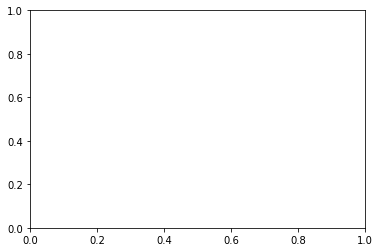

In [28]:
plt.figure()
plt.plot(range(3,12), ptrmm, label='trmm')
plt.plot(range(3,12), pgpm, label='gpm')
plt.plot(range(3,12), ptrmm40, label='trmm40')
plt.legend()

3 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
4 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
5 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
6 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
7 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
8 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
9 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
10 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
11 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
3 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
4 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/

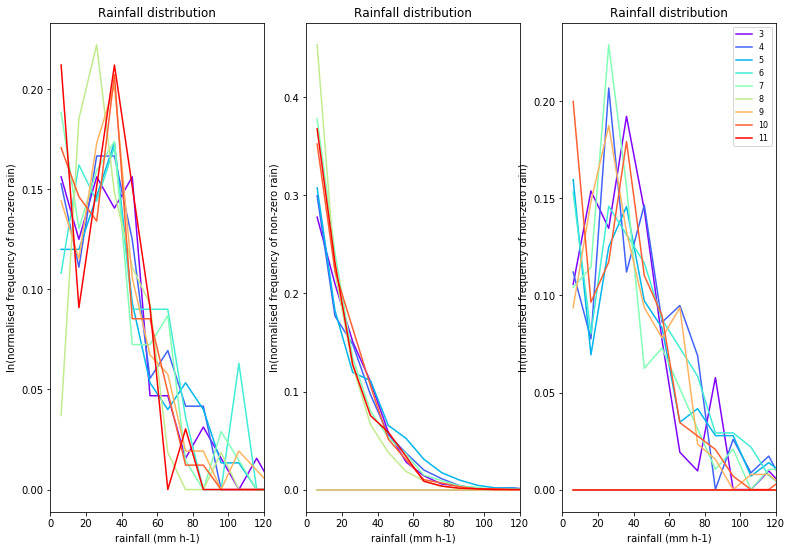

In [29]:
f = plt.figure(figsize=(13,9))

for ids, data in enumerate([obs_trmm, obs_gpm, obs_40]):
    #ipdb.set_trace()
    ax = f.add_subplot(1,3,ids+1)
    colors = cm.rainbow(np.linspace(0,1,9))
    for m,c in zip(np.arange(3,12),colors):
        #print(m)
        
        monthly = (data['prcp'])[data['month'] == m]

        print(m, np)

        #ipdb.set_trace()
        weights = np.ones_like(monthly) / float(len(monthly))
        hist, h = np.histogram(monthly, bins=np.arange(1,201+1,10),  range=(1,201), weights=weights)
        #print(np.arange(20,120+1,10))
        bins=np.arange(1,201+1,10)
        #line, = ax.semilogy(hist, color=c, lw=2, label=str(m))
        mid = bins[1::]-5
        ax.plot(mid,hist, color=c, label=str(m))
    plt.ylabel('ln(normalised frequency of non-zero rain)')
    plt.xlim((0,120))
    plt.xlabel('rainfall (mm h-1)')
    
    plt.title('Rainfall distribution')

plt.legend(fontsize=8)


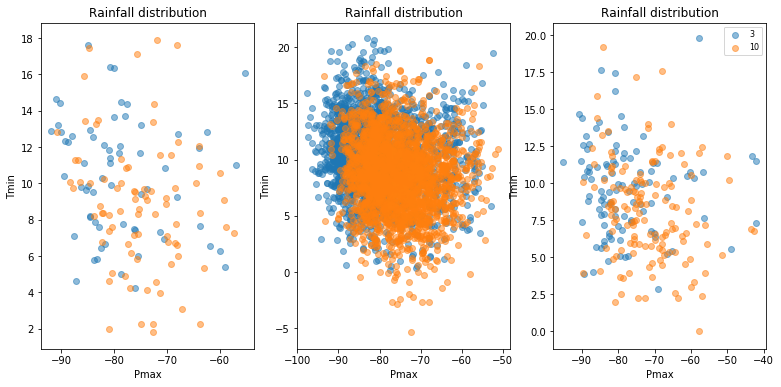

In [30]:
f = plt.figure(figsize=(13,6))

for ids, data in enumerate([obs_trmm, obs_gpm, obs_40]):
    #ipdb.set_trace()
    ax = f.add_subplot(1,3,ids+1)
    colors = cm.rainbow(np.linspace(0,1,9))
    for m,c in zip([3,10],colors):
        #print(m)
#         if m == 5:
        monthly = (data)[data['month'] == m]
#         if m == 9:
        monthly = (data)[data['month'] == m]

        ax.scatter(monthly['tmin'], monthly['shear'], label=str(m), alpha=0.5)
    plt.ylabel('Tmin')
    #plt.xlim((0,120))
    plt.xlabel('Pmax')
    
    plt.title('Rainfall distribution')

plt.legend(fontsize=8)


In [31]:
pos1 = (ds.u650<0) & (ds.area>=5000)# all storms, without trmm overpass - matchup via storm centre points

In [32]:
np.sum(pos1)

11481

In [33]:
oposi = (obs_gpm.u650<0) & (obs_gpm.area>=5000) & (obs_gpm.prcp>=1)# & ((obs_gpm.month>=9) | (obs_gpm.month<=5))

In [34]:
obs_gpm

,area,lat,lon,month,prcp,q925,shear,tmean,tmin,u650,u925
0,15175,8.042260,7.086056,7,16.436291,14.771931,4.242306,-59.368354,-66.000000,-0.871464,3.370841
2,25900,5.383124,5.871901,3,40.799622,15.283607,11.599382,-67.618949,-84.491096,-8.650678,2.948704
3,18875,5.657608,9.794786,3,41.538076,11.851226,5.548393,-68.572320,-81.253862,-4.378613,1.169780
4,8625,5.251607,11.170472,8,4.185770,16.826462,-0.868521,-59.640201,-68.415718,3.606708,2.738187
5,5625,6.794109,9.875093,3,0.027387,14.376267,14.587403,-61.164508,-71.528749,-12.508322,2.079082
7,5050,6.118873,-0.763059,11,25.979994,15.512910,5.897785,-63.932756,-76.043866,-4.892231,1.005554
8,9175,7.607427,-9.920333,8,3.956107,14.651157,-1.993850,-57.010670,-65.814378,4.999868,3.006018
9,6350,6.134304,7.743775,8,9.723751,14.361298,6.079646,-64.095732,-74.291615,-3.830828,2.248818
10,12700,5.550144,11.265918,8,16.874041,15.085265,1.735940,-57.706569,-71.352158,-1.495301,0.240639
11,11425,5.398523,10.319106,8,5.116616,12.737813,3.269078,-58.910107,-67.941221,-1.111741,2.157337


In [35]:
ds_march = ds[pos1]
obsp = obs_gpm[oposi]

In [36]:
obsp.keys()

Index(['area', 'lat', 'lon', 'month', 'prcp', 'q925', 'shear', 'tmean', 'tmin',
       'u650', 'u925'],
      dtype='object')

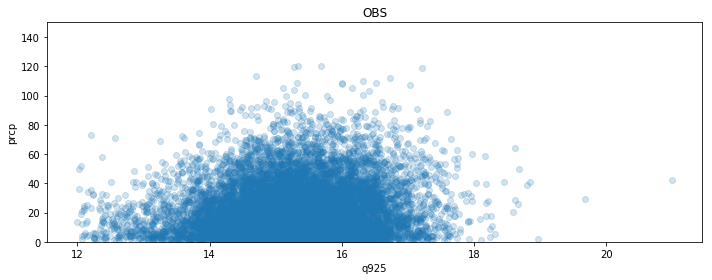

In [37]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)
isqq = obsp.q925>12
plt.scatter(obsp.where(isqq).q925, obsp.where(isqq).prcp, alpha=0.2)
plt.xlabel('q925')
plt.title('OBS')
plt.ylabel('prcp')
ax.set_ylim(0,150)
plt.tight_layout()

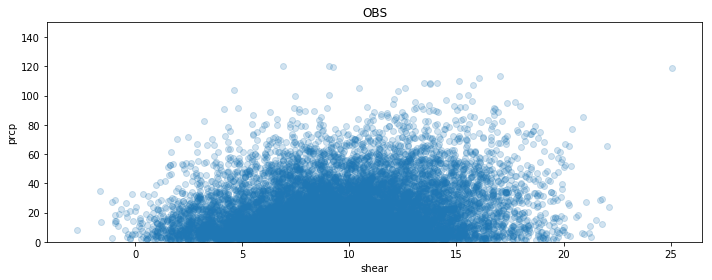

In [38]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)
isqq = obsp.q925>12
plt.scatter(obsp.where(isqq).shear, obsp.where(isqq).prcp, alpha=0.2)
plt.xlabel('shear')
plt.title('OBS')
plt.ylabel('prcp')
ax.set_ylim(0,150)
plt.tight_layout()

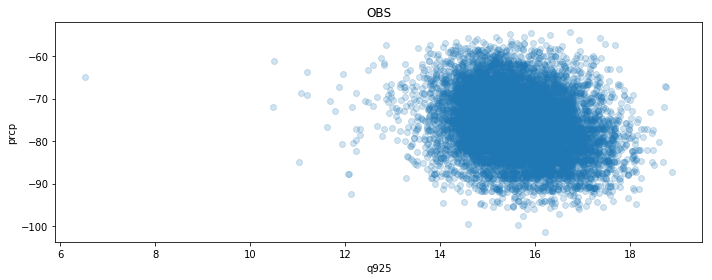

In [39]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)
plt.scatter(ds_march.q925, ds_march.tmin, alpha=0.2)
plt.xlabel('q925')
plt.title('OBS')
plt.ylabel('prcp')
#ax.set_ylim(0,150)
plt.tight_layout()

In [40]:
def density_plot(v1,v2,v3):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())

    r = u_stat.pcor(v1,v2,v3)
    r = stats.pearsonr(v1,v2)
    print('pears', stats.pearsonr(v1,v2))
    
    return data, r

In [41]:
def plot_scatter_month(dat):
    fig = plt.figure(figsize=(9, 5), dpi=100)
    cc=11
    ax1 = fig.add_subplot(221)

    data1, r1 = density_plot(dat.u650, dat.tmin, dat.q925)

    mappable = ax1.scatter(dat.u650, dat.tmin, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
    ax1.set_ylabel('Min. T')
    ax1.set_xlabel('u925hPa')
    ax1.set_title('P-corr. shear/Tmin | q removed: '+str(np.round(r1[0], decimals=2)), fontsize=cc)
    ax1.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(222)

    data2, r2 = density_plot(dat.q925, dat.tmin, dat.shear)

    mappable = ax2.scatter(dat.q925, dat.tmin, c=data2, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 18)
    ax2.set_ylabel('Min T')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. tt/qq | shear removed: '+str(np.round(r2[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(223)

    data3, r3 = density_plot(dat.q925, dat.shear, dat.u650)

    mappable = ax2.scatter(dat.q925, dat.shear, c=data3, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 18)
    ax2.set_ylabel('shear')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. qq/shear | umax removed: '+str(np.round(r3[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(224)

    data4, r4 = density_plot(dat.area, dat.tmin, dat.u925)

    mappable = ax2.scatter(dat.area, dat.tmin , c=data4, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    #ax2.set_xlim(0, 10)
    ax2.set_ylabel('min T')
    ax2.set_xlabel('area')
    ax2.set_title('P-corr. qq700/tmin | u650hPa removed: '+str(np.round(r4[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    plt.tight_layout()



In [42]:
def plot_scatter_month_double(dat, dat2):
    fig = plt.figure(figsize=(9, 5), dpi=100)
    cc=11
    ax1 = fig.add_subplot(221)

    data1, r1 = density_plot(dat.shear, dat.tmin, dat.q925)

    mappable = ax1.scatter(dat.shear, dat.tmin, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
    ax1.set_ylabel('Min. T')
    ax1.set_xlabel('u925hPa')
    ax1.set_title('P-corr. shear/Tmin | q removed: '+str(np.round(r1[0], decimals=2)), fontsize=cc)
    ax1.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(222)

    data2, r2 = density_plot(dat.q925, dat.tmin, dat.shear)

    mappable = ax2.scatter(dat.q925, dat.tmin, c=data2, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 20)
    ax2.set_ylabel('Min T')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. tt/qq | shear removed: '+str(np.round(r2[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax1 = fig.add_subplot(223)

    data1, r1 = density_plot(dat2.shear, dat2.tmin, dat2.q925)

    mappable = ax1.scatter(dat2.shear, dat2.tmin, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
    ax1.set_ylabel('Min. T')
    ax1.set_xlabel('u925hPa')
    ax1.set_title('P-corr. shear/Tmin | q removed: '+str(np.round(r1[0], decimals=2)), fontsize=cc)
    ax1.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(224)

    data2, r2 = density_plot(dat2.q925, dat2.tmin, dat2.shear)

    mappable = ax2.scatter(dat2.q925, dat2.tmin, c=data2, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 20)
    ax2.set_ylabel('Min T')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. tt/qq | shear removed: '+str(np.round(r2[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    plt.tight_layout()

In [43]:
ds_march.keys()

Index(['area', 'lat', 'lon', 'month', 'q700', 'q925', 'shear', 'tmean', 'tmin',
       'u650', 'u925'],
      dtype='object')

pears (0.28159407312022644, 3.0969563776485213e-208)
pears (-0.23970457036192488, 9.769560699663986e-150)
pears (0.2188844826887362, 1.4201238170932914e-124)
pears (-0.4249520844609414, 0.0)


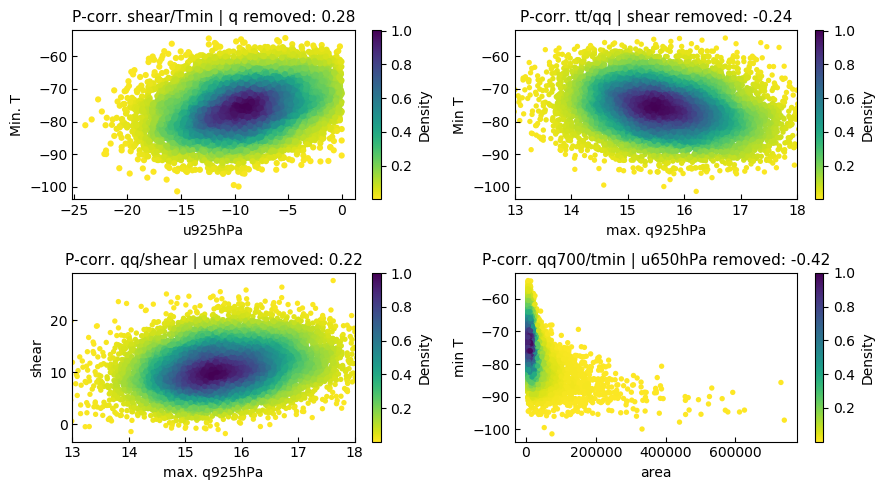

In [44]:
plot_scatter_month(ds_march)

pears (0.3604060233132517, 0.0)
pears (-0.25956537410723524, 4.0355674436498773e-197)
pears (0.20351055367566626, 2.45913220733686e-120)
pears (-0.4222439284398509, 0.0)


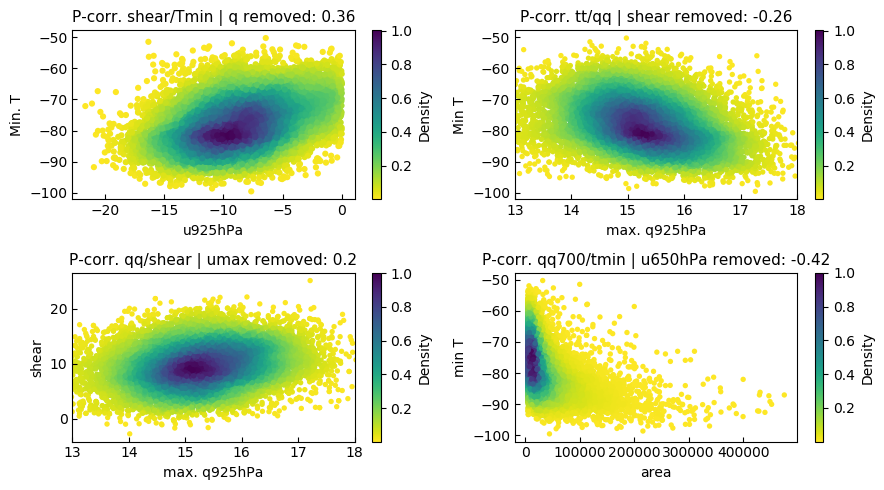

In [45]:
plot_scatter_month(obsp)

In [46]:
alln=7
nbs= alln
nbq= alln
nba = alln

p1 = 1 #5
p2 = 99

shearb_march = np.percentile(ds_march.shear[(ds_march.shear>=np.percentile(ds_march.shear,p1)) & (ds_march.shear<=np.percentile(ds_march.shear,p2))], np.linspace(0,100,nbs)) #np.percentile(ds_march.shear[(ds_march.shear>=3) & (ds_march.shear<=17)], np.linspace(0,100,nbs))

# shearb_march = np.percentile(ds_march.shear[(ds_march.shear>=3) & (ds_march.shear<=17)], np.linspace(0,100,nbs))
# shearc_march = np.percentile(cp4_march.shear[(cp4_march.shear>=8) & (cp4_march.shear<=20)], np.linspace(0,100,nbs))
# shear25_march = np.percentile(cp25_march.shear[(cp4_march.shear>=8) & (cp25_march.shear<=20)], np.linspace(0,100,nbs))

abins = np.linspace(5000,250000, nba)
qbinsb_march = np.linspace(np.percentile(ds_march.q925, 2) , np.percentile(ds_march.q925, p2), nbq) 

nbqq = 7
nbss = 7

p1 = 10
p2 = 90

shear_obsp = np.percentile(obsp.shear[(obsp.shear>=np.percentile(obsp.shear,1)) & (obsp.shear<=np.percentile(obsp.shear,99))], np.linspace(0,100,nbss)) # np.percentile(cp25_march.shear[(cp4_march.shear>=8) & (cp25_march.shear<=20)], np.linspace(0,100,nbs))
#np.percentile(obsp.shear[(obsp.shear>=3) & (obsp.shear<=17)], np.linspace(0,100,nbss))

qbinso = np.linspace(np.percentile(obsp.q925, 2) , np.percentile(obsp.q925, 99), nbqq)


In [47]:
def create_2dhist(ds, xbins,ybins):
#     sheardiff = shearbins[0:-1]+((xbins[1::]-shearbins[0:-1])/2)[0]
#     qdiff= qbins[0:-1] + ((qbins[1::]-qbins[0:-1])/2)[0]

    outperc_tt = np.zeros((len(ybins),len(xbins)))
    outperc_pp = np.zeros((len(ybins),len(xbins)))
    outval = np.zeros((len(ybins),len(xbins)))
    outarea_ds = np.zeros((len(ybins),len(xbins)))

    corrlist = []
    stdlist = []
    
    for isq, qql in enumerate(ybins[0:-1]):
        for issh, shl in enumerate(xbins[0:-1]):

            poss_ds = (ds.shear >= shl) & (ds.shear < xbins[issh+1]) & (ds.q925>=qql) & (ds.q925 < ybins[isq+1])
          
            try:
                ds_mean = np.percentile(ds.tmin[poss_ds], 50)
            except IndexError:
                ds_mean = np.nan
                
            try:
                prcp_mean = np.percentile(ds.prcp[poss_ds], 50)
            except:
                prcp_mean = np.nan

            try:
                ds_amean = np.percentile(ds.area[poss_ds], 50)
            except IndexError:
                ds_amean = np.nan

            outarea_ds[issh,isq] = ds_amean
            outperc_tt[issh,isq] = ds_mean
            outperc_pp[issh,isq] = prcp_mean

            outval[issh,isq] = np.sum(poss_ds)
            
    return outperc_tt, outperc_pp, outarea_ds, outval

In [48]:
def hist2d_plot(data,xbins, ybins, vmin, vmax, valid=None):
    f = plt.figure()
    ax5 = f.add_subplot(111)
    X, Y = np.meshgrid(xbins,ybins)
    cmapp = uplot.discrete_cmap(8, base_cmap='RdBu_r')
    if valid is not None:
        data[valid<50] = np.nan
    Zm = ma.masked_where(np.isnan(data),data)

    mappable = ax5.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=vmin, vmax=vmax) # viridis_rvmin=20, vmax=40
    #mappable = ax5.pcolormesh(X, Y, Zm.T, cmap=cmapp) # viridis_rvmin=20, vmax=40

    ax5.set_ylabel('Max. q925hPa')
    ax5.set_xlabel('Max. u925hPa (equally populated)')
    ax5.set_title('')
    cbar = f.colorbar(mappable, ticks=np.linspace(vmin,vmax,9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
    cbar.set_label('90th centile max. rain')
    plt.show()

In [49]:
def hist2d_quatro(data, valid=False):
    f = plt.figure(figsize=(10,7))
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,2,i+1)
      
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap='RdBu_r')
        if valid:
            
            dat['data'][dat['valid']<10] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 

In [50]:
def hist2d_six(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(15,8))
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,3,i+1)
        if i>2:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<40] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    plt.savefig(cnst.network_data + 'figs/CLOVER/fig3_pcp.png')

In [51]:
def hist2d_three(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(15,4))
    for i, dat in enumerate(data):
        ax = f.add_subplot(1,3,i+1)
        if i>0:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<40] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])
        ax.set_facecolor('grey')
        #ax.set_ylim(13,17.5)

    plt.tight_layout() 
    plt.savefig(cnst.network_data + 'figs/CLOVER/fig3_obsOnly.png')

In [52]:
dsperc_mar, dsp_mar, dsarea_mar, dsval_mar = create_2dhist(ds_march, shearb_march, qbinsb_march)

In [53]:
cpobsperc, pcobs, obsarea, obsval = create_2dhist(obsp, shear_obsp, qbinso)

In [54]:
print(ds_march.shear.mean())
print(ds_march.q925.mean())

10.781728921405445
15.630504314872617


In [55]:
tmin_dic = {
    'data' : dsperc_mar,
    'ybins' : qbinsb_march,
    'xbins' : shearb_march,
    'title' : 'Median minimum temperature',
    'valid' : dsval_mar,
    'cbarlabel' : '${\circ}$C',
    'vmin' : np.percentile(dsperc_mar[(dsperc_mar!=0) & np.isfinite(dsperc_mar)],1),
    'vmax' : np.percentile(dsperc_mar[(dsperc_mar!=0) & np.isfinite(dsperc_mar)],99),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

pcobs[pcobs==0]=np.nan
prcp_dic = {
    'data' : pcobs,
    'ybins' : qbinso,
    'xbins' : shear_obsp,
    'title' : 'Median maximum precipitation',
    'valid' : obsval,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],1),
    'vmax' : np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],99),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

area_dic = {
    'data' : dsarea_mar,
    'ybins' : qbinsb_march,
    'xbins' : shearb_march,
    'title' : 'Observed',
    'valid' : dsval_mar,
    'cbarlabel' : '10th centile Tmin',
    'vmin' : np.percentile(dsarea_mar[(dsarea_mar!=0) & np.isfinite(dsarea_mar)],1),
    'vmax' : np.percentile(dsarea_mar[(dsarea_mar!=0) & np.isfinite(dsarea_mar)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}

(array([  50.,  496., 1628., 2853., 2936., 2104., 1029.,  311.,   69.,
           5.]),
 array([-1.8368516 ,  1.10604668,  4.04894495,  6.99184322,  9.9347415 ,
        12.87763977, 15.82053804, 18.76343632, 21.70633459, 24.64923286,
        27.59213114]),
 <a list of 10 Patch objects>)

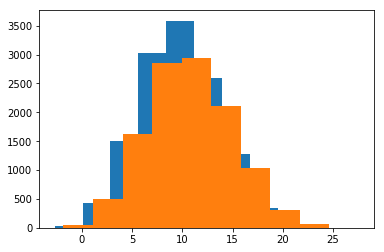

In [56]:
plt.hist(obsp.shear)
plt.hist(ds_march.shear)

In [57]:
data_list = [tmin_dic, prcp_dic, area_dic]

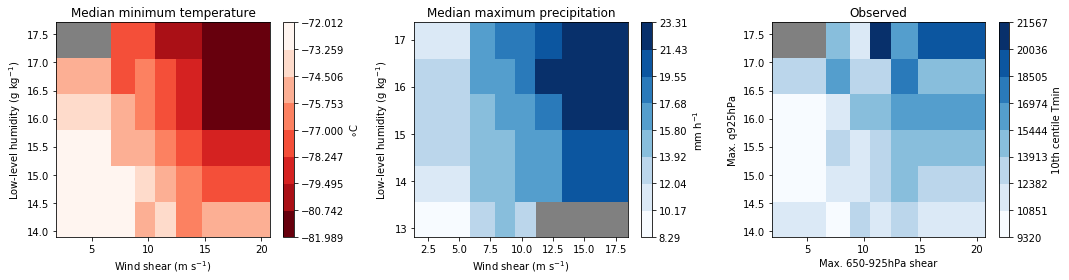

In [58]:
hist2d_three(data_list, valid=True)

[ 2.49754882  5.07004547  6.63404465  7.71145115  8.65271555  9.60002041
 10.5633297  11.59219589 12.82415134 14.42644096 18.53509521]
bigger than 2.497548818588257
smaller than 5.070045471191406
bigger than 5.070045471191406
smaller than 6.634044647216797
bigger than 6.634044647216797
smaller than 7.711451148986817
bigger than 7.711451148986817
smaller than 8.652715549468995
bigger than 8.652715549468995
smaller than 9.600020408630371
bigger than 9.600020408630371
smaller than 10.563329696655273
bigger than 10.563329696655273
smaller than 11.592195892333987
bigger than 11.592195892333987
smaller than 12.824151344299317
bigger than 12.824151344299317
smaller than 14.426440963745119
bigger than 14.426440963745119
smaller than 18.5350952148438


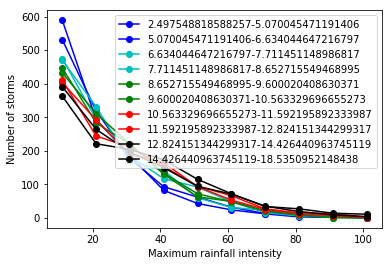

In [59]:
p = np.array(obsp.shear)
t = np.array(obsp.prcp)
q = np.array(obsp.q925)


bins = np.percentile(p[p>=2], np.linspace(1,99,11))#np.arange(4, 29, 2)  # compute probability per temperature range (1degC)
print(bins)
shearlist = []
pprob = []
qqprob = []
plist = []
#ax5 = fig.add_subplot(236)

colours = [ 'b', 'b',  'c', 'c', 'g', 'g', 'r', 'r', 'k', 'k']

for ids, c in enumerate(bins[0:-1]):
    pos = np.where((p >= c) & (p < bins[ids+1]))
    print('bigger than',c )
    print('smaller than', bins[ids+1])

    try:
        cmean = np.percentile(t[pos], 50)
    except IndexError:
        cmean = np.nan

    H, binz = np.histogram(t[pos], bins=np.arange(1,111,10))
    #H, bins = ustat.histo_frequency(t[pos])

    plt.plot(binz[0:-1]+(binz[1::]-binz[0:-1]), H, 'o-',  label=str(c)+'-'+str(bins[ids+1]) , color=colours[ids])

    prob = np.sum(t[pos]>=55) / np.sum(t[pos]>=1)
    qprob = np.sum(q[pos]>=17.5) / np.sum(q[pos]>=12)
    pprob.append(prob)
    qqprob.append(qprob)
    plist.append(cmean)
    shearlist.append(((bins[ids+1])-c)/2)

plt.xlabel('Maximum rainfall intensity')
plt.ylabel('Number of storms')
plt.plot()
plt.legend()
xtick = bins[0:-1]

xtickwidth= (bins[1::]-bins[0:-1])

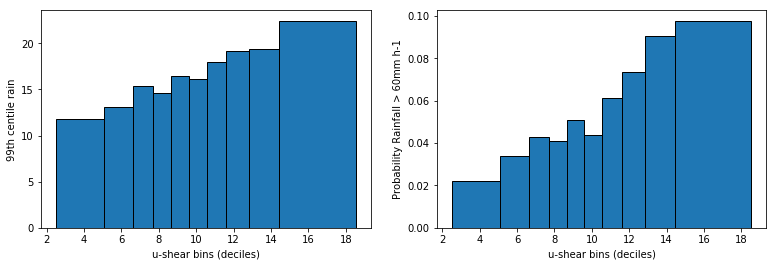

In [60]:
f = plt.figure(figsize=(13,4))
ax4 = f.add_subplot(121)

ax4.bar(xtick, plist, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('99th centile rain')

ax4 = f.add_subplot(122)

ax4.bar(xtick, pprob, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('Probability Rainfall > 60mm h-1')

bar_dic = {
'xtick' : xtick,
'ytick' : pprob,
'width' : xtickwidth
}

Text(0, 0.5, 'Probability Rainfall > 60mm h-1')

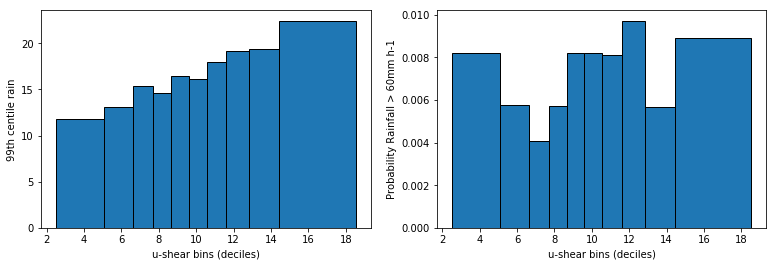

In [61]:
f = plt.figure(figsize=(13,4))
ax4 = f.add_subplot(121)

ax4.bar(xtick, plist, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('99th centile rain')

ax4 = f.add_subplot(122)

ax4.bar(xtick, qqprob, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('Probability Rainfall > 60mm h-1')

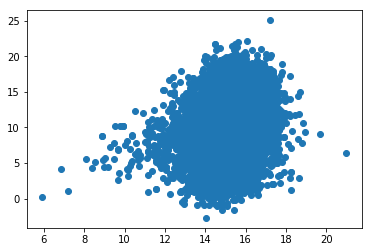

In [62]:
plt.scatter(obsp.q925, obsp.shear)

In [63]:
np.percentile(obsp.prcp[obsp.prcp>1],90)

46.317454709697074

[13.00113648 14.25798672 14.63516615 14.91720043 15.14933786 15.38362913
 15.63470438 15.93454306 16.33950695 20.99131607]
bigger than 13.001136481761932
smaller than 14.257986719409626
bigger than 14.257986719409626
smaller than 14.63516615331173
bigger than 14.63516615331173
smaller than 14.917200431227684
bigger than 14.917200431227684
smaller than 15.149337860445181
bigger than 15.149337860445181
smaller than 15.383629128336906
bigger than 15.383629128336906
smaller than 15.634704381227492
bigger than 15.634704381227492
smaller than 15.93454306324323
bigger than 15.93454306324323
smaller than 16.339506953954697
bigger than 16.339506953954697
smaller than 20.991316065192223


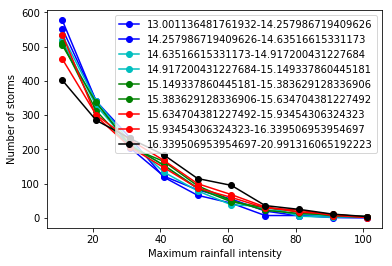

In [64]:
p = np.array(obsp.q925)
t = np.array(obsp.prcp)
q = np.array(obsp.shear)


bins = np.percentile(p[p>=13], np.linspace(0,100,10))#np.arange(4, 29, 2)  # compute probability per temperature range (1degC)
print(bins)
shearlist = []
pprob = []
qqprob = []
plist = []
#ax5 = fig.add_subplot(236)

colours = [ 'b', 'b',  'c', 'c', 'g', 'g', 'r', 'r', 'k', 'k']

for ids, c in enumerate(bins[0:-1]):
    pos = np.where((p >= c) & (p < bins[ids+1]))
    print('bigger than',c )
    print('smaller than', bins[ids+1])

    try:
        cmean = np.percentile(t[pos], 50)
    except IndexError:
        cmean = np.nan

    H, binz = np.histogram(t[pos], bins=np.arange(1,111,10))
    #H, bins = ustat.histo_frequency(t[pos])

    plt.plot(binz[0:-1]+(binz[1::]-binz[0:-1]), H, 'o-',  label=str(c)+'-'+str(bins[ids+1]) , color=colours[ids])

    prob = np.sum(t[pos]>55) / np.sum(t[pos]>1)
    qprob = np.sum(q[pos]>=18) / np.sum(q[pos]>=0)
    pprob.append(prob)
    qqprob.append(qprob)
    plist.append(cmean)
    shearlist.append(((bins[ids+1])-c)/2)

plt.xlabel('Maximum rainfall intensity')
plt.ylabel('Number of storms')
plt.plot()
plt.legend()
xtick = bins[0:-1]

xtickwidth= (bins[1::]-bins[0:-1])

Text(0, 0.5, 'Probability Rainfall > 60mm h-1')

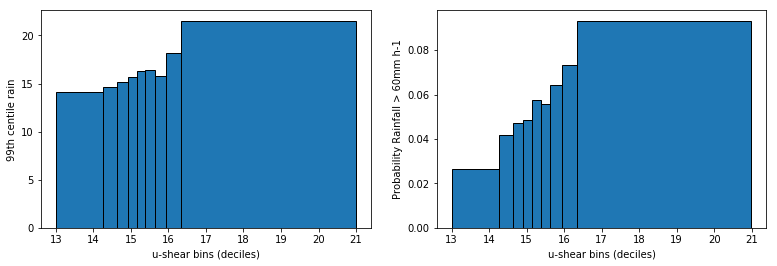

In [65]:
f = plt.figure(figsize=(13,4))
ax4 = f.add_subplot(121)

ax4.bar(xtick, plist, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('99th centile rain')

ax4 = f.add_subplot(122)

ax4.bar(xtick, pprob, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('Probability Rainfall > 60mm h-1')

Text(0, 0.5, 'Probability Rainfall > 60mm h-1')

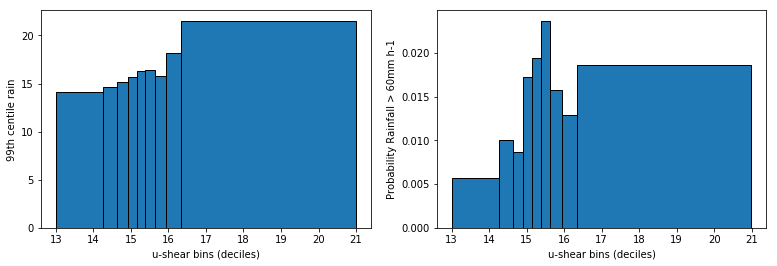

In [66]:
f = plt.figure(figsize=(13,4))
ax4 = f.add_subplot(121)

ax4.bar(xtick, plist, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('99th centile rain')

ax4 = f.add_subplot(122)

ax4.bar(xtick, qqprob, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('Probability Rainfall > 60mm h-1')

In [67]:
u_stat.pcor(obsp.prcp, obsp.q925,obsp.shear)

(0.08506665383961202, 4.254178274285985e-22)

In [68]:
u_stat.pcor(obsp.prcp, obsp.shear,obsp.q925)

(0.16314763619235456, 1.931428248323986e-77)

In [69]:
def sort_vars():
    q925 = np.array(obsp.shear)
    shears = np.array(obsp.q925)

    sort = np.argsort(q925)
    q = q925[sort]

    shear = shears[sort]
    tmin = np.array(obsp.prcp)[sort]
    
    linsp = np.linspace(0,len(q925)-1,12)
    #linsp = np.percentile(q925[q925>=2], np.linspace(0,99,11))
    
    inds = np.round(linsp).astype(int)

    f=plt.figure(figsize=(13,9))
    ax = f.add_subplot(311)
    plt.plot(q)
    ax = f.add_subplot(312)
    plt.plot(shear,'r')
    ax = f.add_subplot(313)
    plt.plot(tmin,'k')
    
    plt.show()
    
    qmean = []
    corr = []
    qcorr = []
    
    for start,end in enumerate(inds[2::]):  #
        #ipdb.set_trace()
        qsample = q[inds[start]:end]
        qmean.append( np.min(qsample)+ (np.max(qsample)-np.min(qsample))/2)
        
        corr.append(stats.pearsonr(shear[inds[start]:end],tmin[inds[start]:end])[0])    

        ttslope, intercept, rc, p, std_err = linregress(shear[start:end],tmin[start:end])
        print(shear[inds[start]], shear[end])
#         ccslope, intercept, rt, p, std_err = linregress(q[start:end], shear[start:end])
#         corr.append(ttslope) 
        qcorr.append(ttslope) 
    return qmean, corr, qcorr

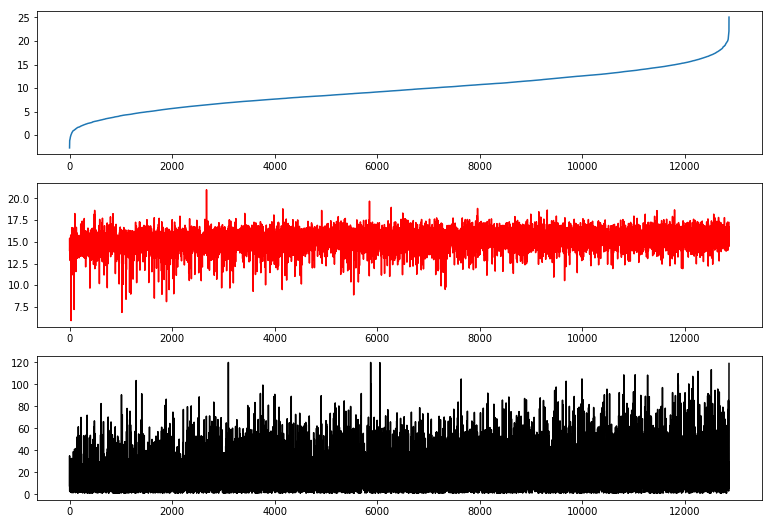

14.014963060617447 14.361297711730003
15.464259311556816 15.152966603636742
14.361297711730003 14.697765000164509
15.152966603636742 11.082010343670845
14.697765000164509 14.62768204510212
11.082010343670845 16.100792214274406
14.62768204510212 15.716355293989182
16.100792214274406 15.895305201411247
15.716355293989182 16.08208194375038
15.895305201411247 17.21157878637314


In [70]:
qmean, corr, slope = sort_vars()

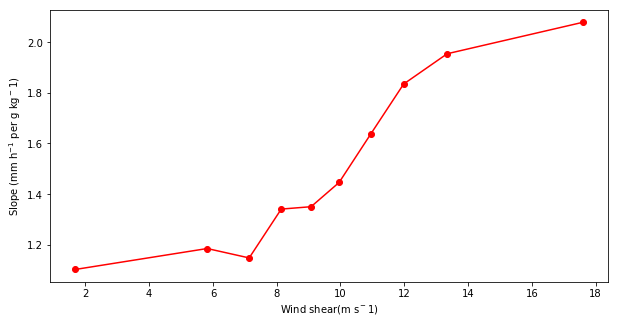

In [71]:
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(111)
ax.plot(qmean,slope, 'ro-')
ax.set_xlabel('Wind shear(m s$^-1$)')
ax.set_ylabel('Slope (mm h$^{-1}$ per g kg$^-1$)')
slope_dic = {
'xtick' : qmean,
'ytick' : slope,
}

In [72]:
def hist2d_bar(data, bar, slope, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(5,10))
    text = ['(a)', '(b)', '(c)']
    for i, dat in enumerate(data):
        ax = f.add_subplot(3,1,i+1)
        if i>0:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<40] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        #plt.text(0.03,0.85, text[i], transform=ax.transAxes, fontsize=14)

        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])
        ax.set_facecolor('grey')
        #ax.set_ylim(13,17.5)
        
    ax4 = f.add_subplot(313)
    ax4.bar(bar['xtick'], np.array(bar['ytick'])*100, bar['width'], align='edge', ec='black')
    ax4.set_xlabel('650-925hPa wind shear (m s$^{-1}$)')
    ax4.set_ylabel('Probability rainfall > 55mm h$^{-1}$ (%)')
    
    ax5 = ax4.twinx()
    ax5.plot(np.array(bar['xtick'])+np.array(bar['width'])/2,slope['ytick'], 'ko-') #np.array(bar['xtick'])+np.array(bar['width'])/2
    ax5.set_xlabel('Wind shear(m s$^-1$)')
    ax5.set_ylabel('Slope (mm h$^{-1}$ per g kg$^-1$)')
    


    plt.tight_layout() 
    plt.annotate(text[0], xy=(0.02, 0.97), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[1], xy=(0.02, 0.64), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[2], xy=(0.02, 0.315), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.savefig(cnst.network_data + 'figs/CLOVER/paper1/fig_2dhist_obsOnly.png')

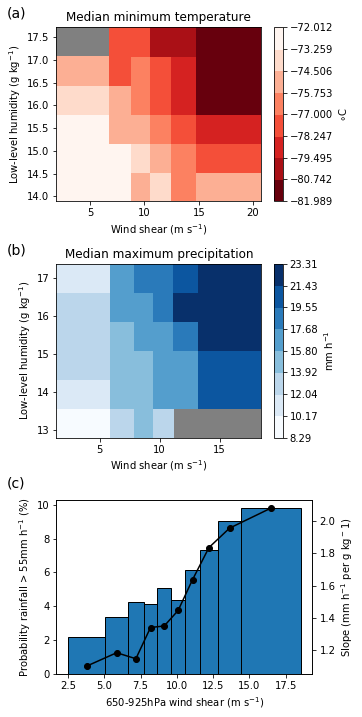

In [73]:
data_list = [tmin_dic, prcp_dic]
hist2d_bar(data_list, bar_dic, slope_dic, valid=False)

In [74]:
obs_gpm.keys()

Index(['area', 'lat', 'lon', 'month', 'prcp', 'q925', 'shear', 'tmean', 'tmin',
       'u650', 'u925'],
      dtype='object')

In [75]:
rainlist = []
for rain in OBS['p']:
    
    rainlist.extend(rain.flat)

In [76]:
len(rainlist)
rain = np.array(rainlist)

In [77]:
np.percentile(rain[rain>1],95)

22.52128280644234

In [78]:
np.percentile(obs_gpm.prcp[obs_gpm.prcp>1],95)

55.66187893957572

In [79]:
dQ = pkl.load(open(cnst.network_data + 'data/CLOVER/saves/deltaQ_plot.p',
                           'rb'))

In [80]:
dQ

{'deltaqy': array([ 0.0501999 ,  0.03189941, -0.040171  ,  0.10085453,  0.19249202,
         0.3573268 ,  0.629571  ,  0.51972616,  0.45858485,  0.6206908 ],
       dtype=float32),
 'tminstd': array([-68.48999023, -69.314991  , -70.38499832, -70.79998779,
        -71.02999878, -71.72999573, -72.54499054, -73.13749695,
        -73.68998718, -74.25999451]),
 'tminx': array([ 5.566946,  7.212179,  8.460169,  9.554464, 10.559965, 11.570615,
        12.676903, 13.901707, 15.342691, 17.408857], dtype=float32),
 'tminy': array([-72.96999359, -74.12499237, -74.80499268, -75.18998718,
        -75.72999573, -76.48999023, -77.38999939, -78.33999634,
        -78.81999207, -79.39499664])}

In [81]:
x = np.array(dQ['tminx'])
corr_all = np.array(dQ['deltaqy'])

qcorr_all = np.array(dQ['tminy'])
qcorr_all_std = np.array(dQ['tminstd'])

In [88]:
def hist2d_deltaQ(data, bar, slope, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(10,7), dpi=300)
    text = ['(a)', '(b)', '(c)', '(d)']
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,2,i+1)
        if i>0:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<40] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        #plt.text(0.03,0.85, text[i], transform=ax.transAxes, fontsize=14)

        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])
        ax.set_facecolor('grey')
        #ax.set_ylim(13,17.5)
        
    ax4 = f.add_subplot(224)
    ax4.bar(bar['xtick'], np.array(bar['ytick'])*100, bar['width'], align='edge', ec='black', color='lightblue')
    ax4.set_xlabel('Wind shear (m s$^{-1}$)')
    ax4.set_ylabel('%')
    
    ax5 = ax4.twinx()
    ax5.plot(np.array(bar['xtick'])+np.array(bar['width'])/2,slope['ytick'], 'ko-') #np.array(bar['xtick'])+np.array(bar['width'])/2
    ax5.set_xlabel('Wind shear(m s$^-1$)')
    ax5.set_ylabel('mm h$^{-1}$ per g kg$^-1$')
    ax5.text(0.01,0.8,'Slope', color='k', transform=ax5.transAxes, fontsize=11)
    ax5.text(0.01,0.9,'Probability Rainfall > 55 mm h$^{-1}$', color='b', transform=ax5.transAxes, fontsize=11)
    
    ax6 = f.add_subplot(223)
    ax6.plot(x,corr_all, 'k-o', label='${\Delta}$q925')
    ax6.fill_between(x,corr_all-0.3, corr_all+0.3, color='b', alpha=0.05)
    ax7 = ax6.twinx()
    ax7.plot(x,qcorr_all, 'ro-', label='Minimum T')
    ax7.fill_between(x,qcorr_all-qcorr_all_std*0.05, qcorr_all+qcorr_all_std*0.05, color='r', alpha=0.05)
    #ax1.errorbar(x, qcorr_all, yerr=qcorr_all_std*0.05, fmt='.k');
    ax7.set_ylim(-85,-70)
    ax7.set_ylim(ax7.get_ylim()[::-1])
    ax6.set_xlabel('Wind shear (m s$^{-1}$)')
    ax6.set_ylabel('g kg$^{-1}$')
    ax7.set_ylabel(r'${\circ}$C')
    ax6.text(0.02,0.8,'${\Delta}$q925', color='k', transform=ax6.transAxes, fontsize=11)
    ax6.text(0.02,0.9,'Minimum temperature', color='r', transform=ax6.transAxes, fontsize=11)

    plt.tight_layout() 
    plt.annotate(text[0], xy=(0.02, 0.95), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[1], xy=(0.53, 0.95), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[2], xy=(0.02, 0.48), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[3], xy=(0.53, 0.48), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.savefig(cnst.network_data + 'figs/CLOVER/paper1/fig_2dhist_obsOnly_deltaQ.png')

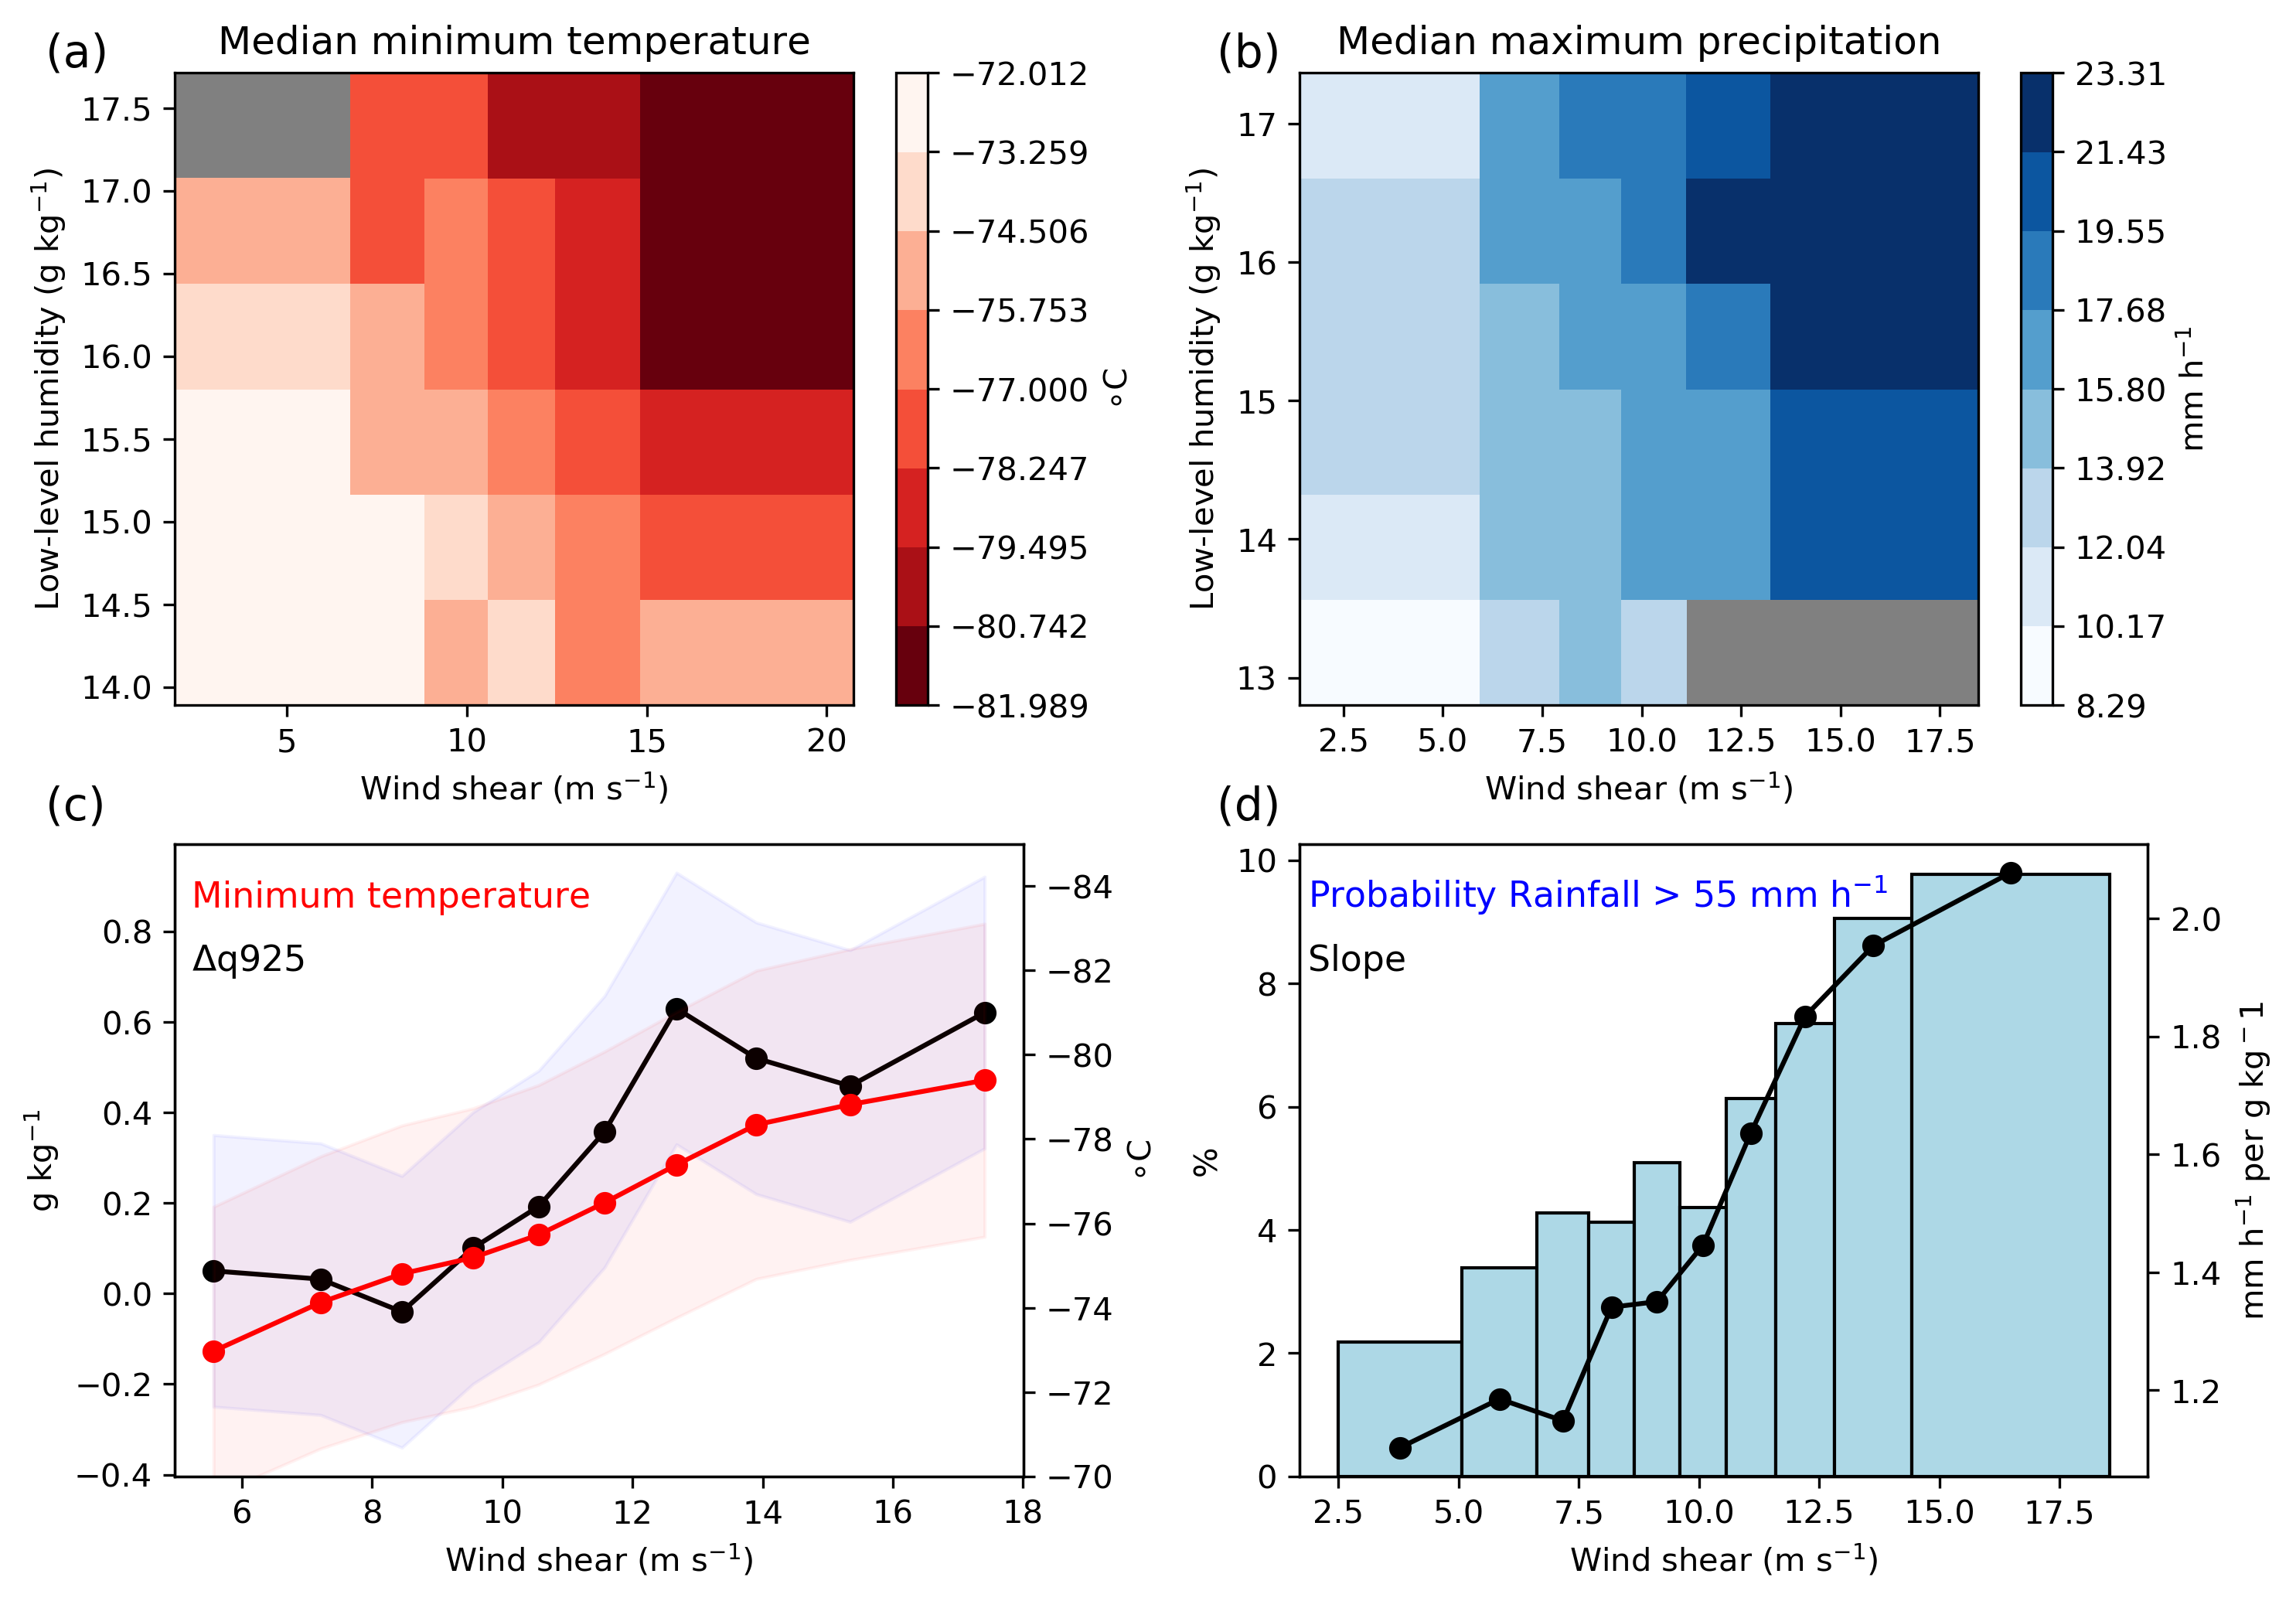

In [89]:
data_list = [tmin_dic, prcp_dic]
hist2d_deltaQ(data_list, bar_dic, slope_dic, valid=False)

In [94]:
def hist2d_deltaQ(data, bar, slope, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(10,4), dpi=300)
    text = ['(a)', '(b)', '(c)', '(d)']
    for i, dat in enumerate(data):
        ax = f.add_subplot(1,2,i+1)
        if i>0:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<40] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        #plt.text(0.03,0.85, text[i], transform=ax.transAxes, fontsize=14)

        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])
        ax.set_facecolor('grey')
        #ax.set_ylim(13,17.5)
        
    plt.tight_layout() 
    plt.annotate(text[0], xy=(0.02, 0.93), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[1], xy=(0.53, 0.93), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    
    plt.savefig(cnst.network_data + 'figs/CLOVER/paper1/2dHist.png')
        
 

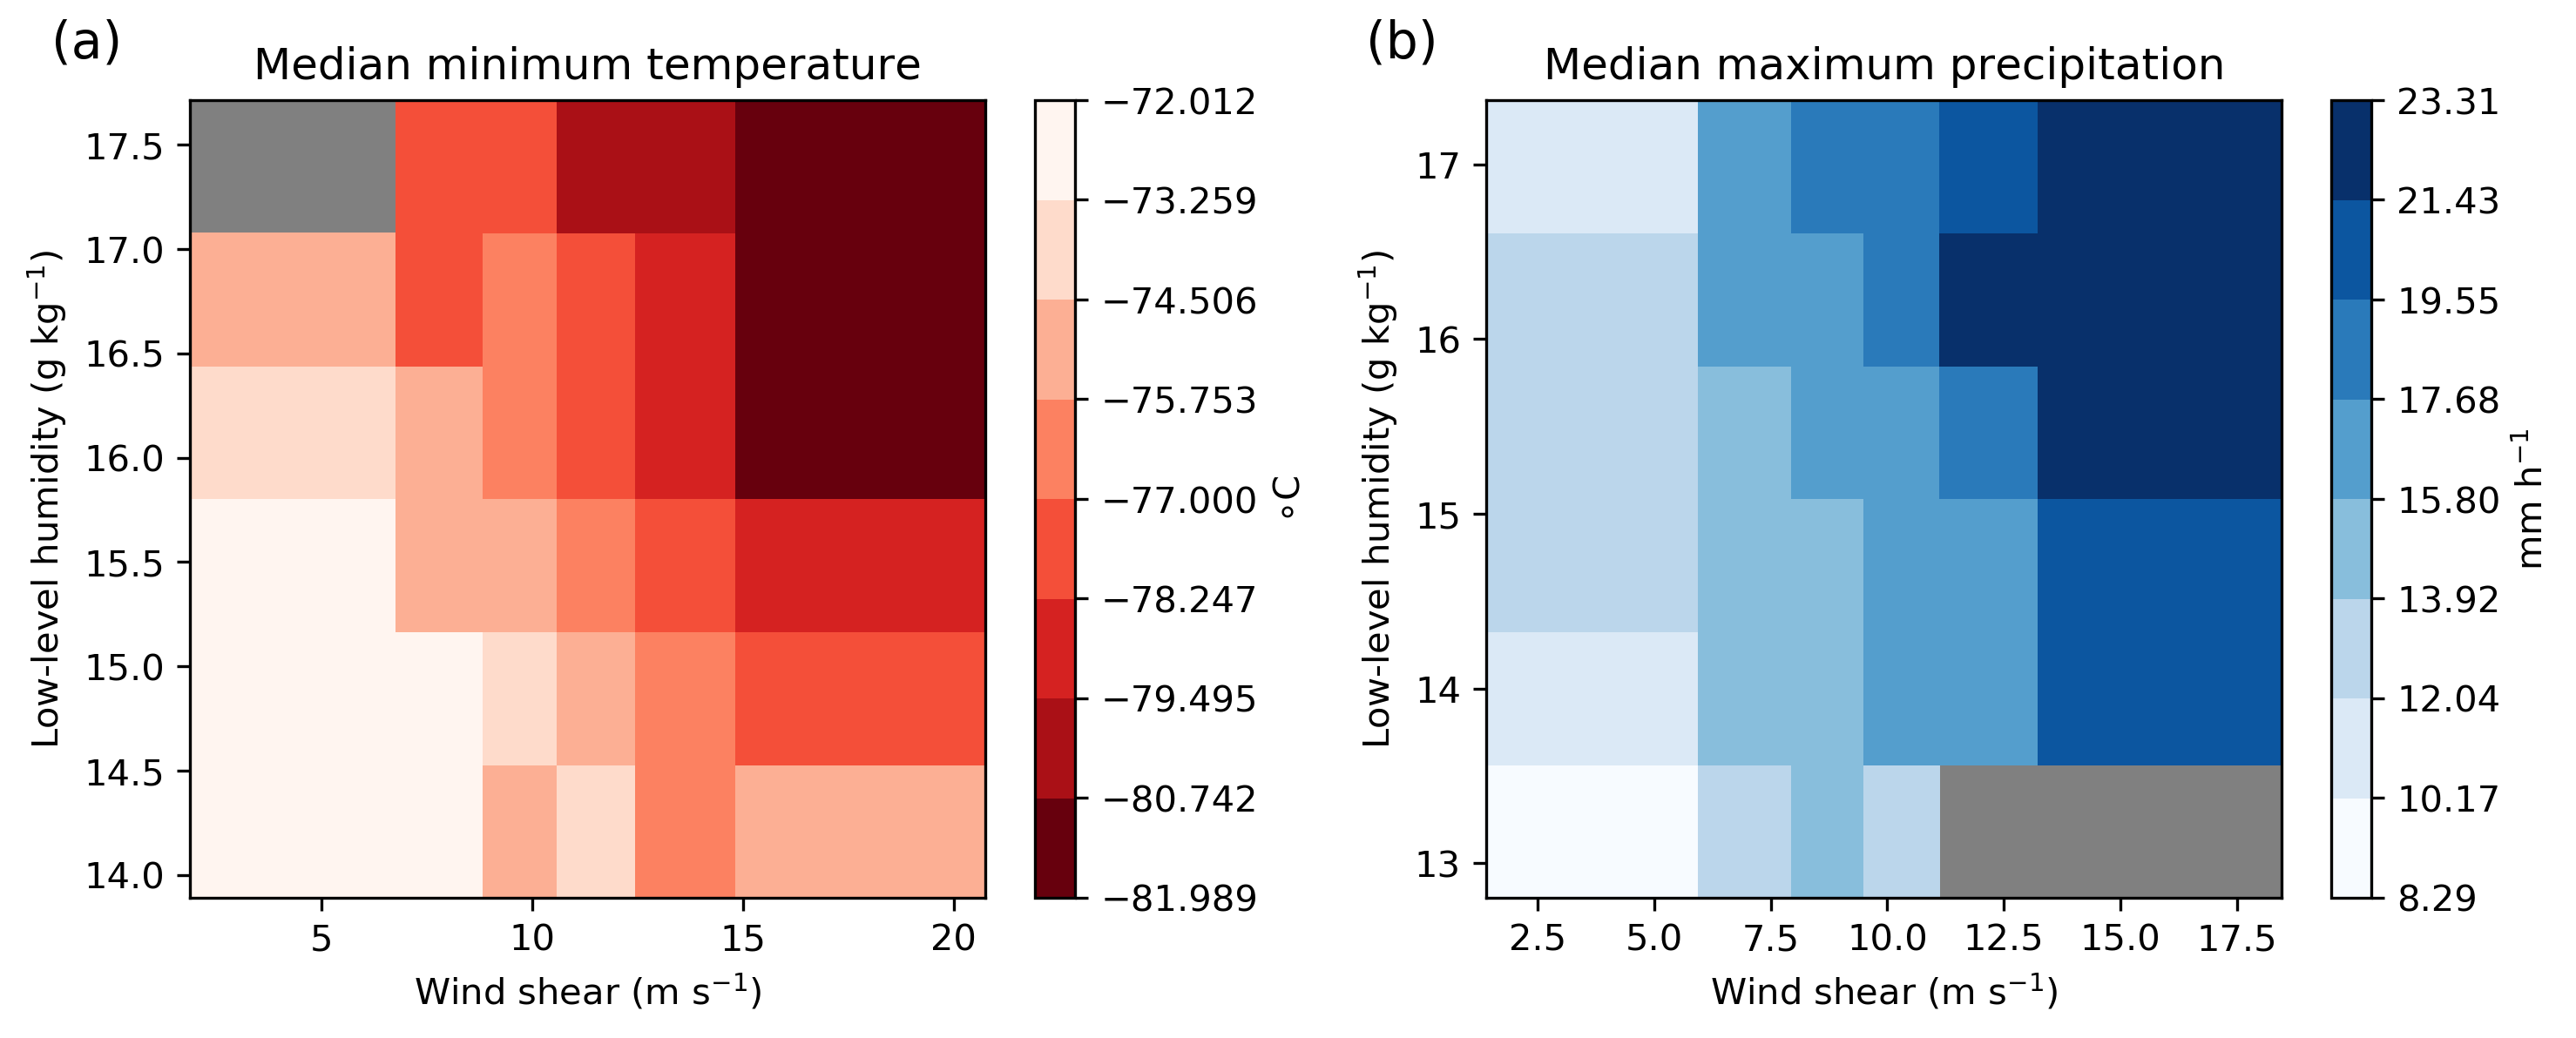

In [95]:
data_list = [tmin_dic, prcp_dic]
hist2d_deltaQ(data_list, bar_dic, slope_dic, valid=False)

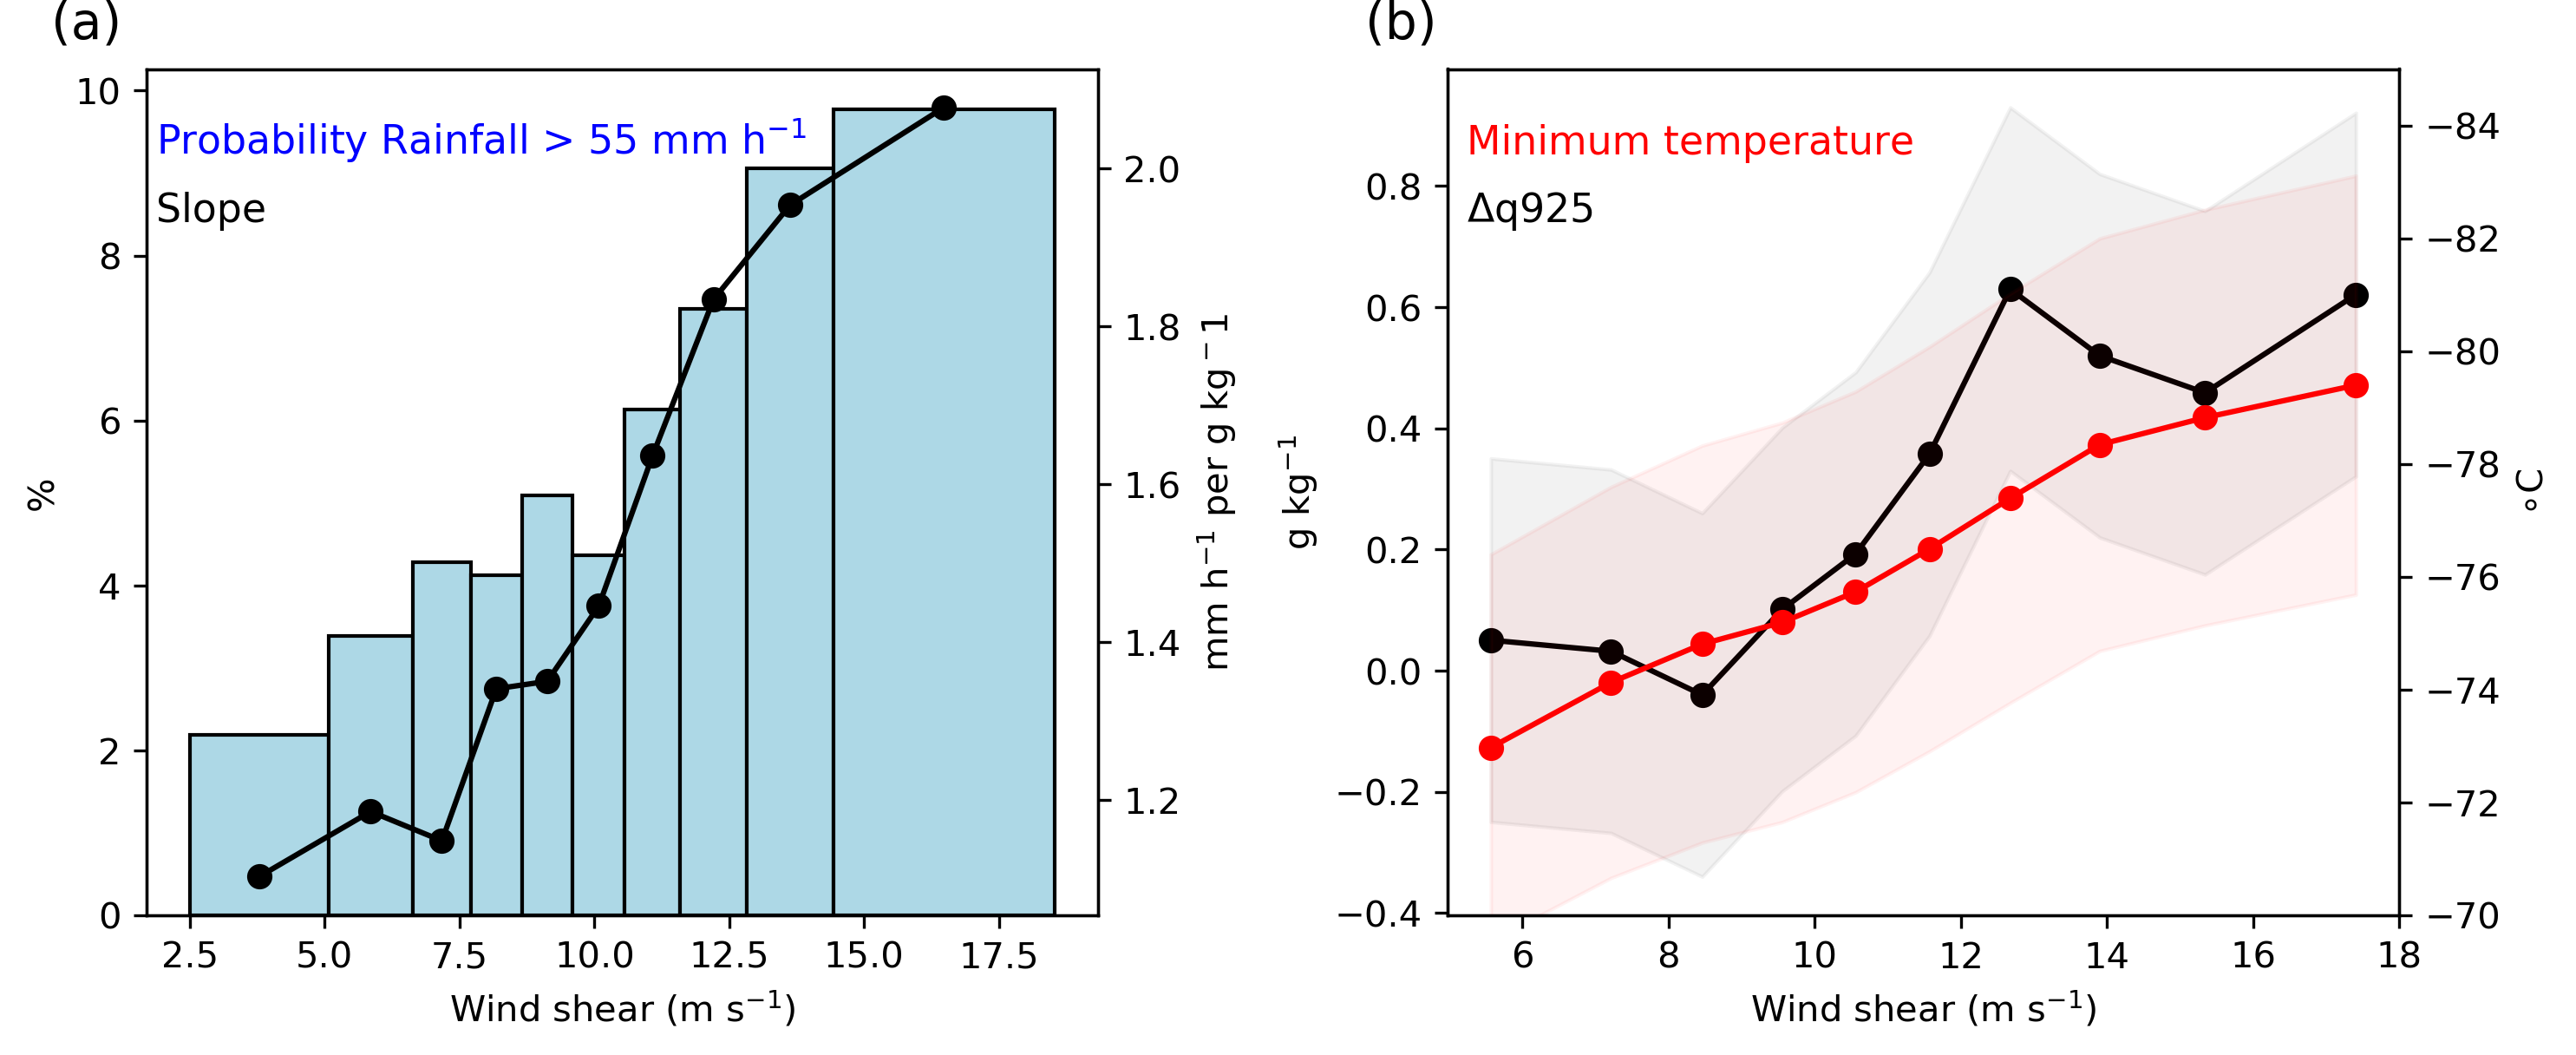

In [105]:
bar = bar_dic
slope = slope_dic

f = plt.figure(figsize=(10,4), dpi=300)
text = ['(a)', '(b)', '(a)', '(b)']
ax4 = f.add_subplot(121)
ax4.bar(bar['xtick'], np.array(bar['ytick'])*100, bar['width'], align='edge', ec='black', color='lightblue')
ax4.set_xlabel('Wind shear (m s$^{-1}$)')
ax4.set_ylabel('%')

ax5 = ax4.twinx()
ax5.plot(np.array(bar['xtick'])+np.array(bar['width'])/2,slope['ytick'], 'ko-') #np.array(bar['xtick'])+np.array(bar['width'])/2
ax5.set_xlabel('Wind shear(m s$^-1$)')
ax5.set_ylabel('mm h$^{-1}$ per g kg$^-1$')
ax5.text(0.01,0.82,'Slope', color='k', transform=ax5.transAxes, fontsize=11)
ax5.text(0.01,0.9,'Probability Rainfall > 55 mm h$^{-1}$', color='b', transform=ax5.transAxes, fontsize=11)

ax6 = f.add_subplot(122)
ax6.plot(x,corr_all, 'k-o', label='${\Delta}$q925')
ax6.fill_between(x,corr_all-0.3, corr_all+0.3, color='k', alpha=0.05)
ax7 = ax6.twinx()
ax7.plot(x,qcorr_all, 'ro-', label='Minimum T')
ax7.fill_between(x,qcorr_all-qcorr_all_std*0.05, qcorr_all+qcorr_all_std*0.05, color='r', alpha=0.05)
#ax1.errorbar(x, qcorr_all, yerr=qcorr_all_std*0.05, fmt='.k');
ax7.set_ylim(-85,-70)
ax7.set_ylim(ax7.get_ylim()[::-1])
ax6.set_xlabel('Wind shear (m s$^{-1}$)')
ax6.set_ylabel('g kg$^{-1}$')
ax7.set_ylabel(r'${\circ}$C')
ax6.text(0.02,0.82,'${\Delta}$q925', color='k', transform=ax6.transAxes, fontsize=11)
ax6.text(0.02,0.9,'Minimum temperature', color='r', transform=ax6.transAxes, fontsize=11)

plt.tight_layout()
plt.annotate(text[2], xy=(0.02, 0.95), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points')
plt.annotate(text[3], xy=(0.53, 0.95), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points')
plt.savefig(cnst.network_data + 'figs/CLOVER/paper1/2dHist_part2.png')